In [143]:
#pip install imageio

In [144]:
##This is a framework of patch-based hyperspectral classification
import os
import time
import random
import spectral
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchinfo import summary
import matplotlib.pyplot as plt
import matplotlib.patches as mpts
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,recall_score,cohen_kappa_score,accuracy_score
from sklearn.preprocessing import minmax_scale
from scipy.io import loadmat
from tqdm.notebook import tqdm
%matplotlib inline

In [145]:
##hypeperameters and experimental settings
RANDOM_SEED=666
MODEL_NAME = '3D2DConvKAN' ## your model name
DATASET = 'IP'  ## PU  IP  SA or your personal dataset
TRAIN_RATE = 0.7  ## ratio of training data
VAL_RATE = 0.2    ## ratio of valuating data
EPOCH = 15    ##number of epoch
VAL_EPOCH = 1  ##interval of valuation
LR = 0.001    ##learning rate
WEIGHT_DECAY = 1e-6  
BATCH_SIZE = 64
DEVICE = 0  ##-1:CPU  0:cuda 0
N_PCA = 15  ## reserved PCA components   0:use origin data
NORM = True  ## normalization or not
PATCH_SIZE = 9 ## patchsize of input 3D cube   1:only spectral sequence
CHECK_POINT = None  ## path of check point model

writer = SummaryWriter(log_dir="C:\\Users\\coolp\\Downloads\\HSIConvKAN-main\\HSIConvKAN-main\\epoch\\logs\\"+MODEL_NAME)

SAVE_PATH = "C:\\Users\\coolp\\Downloads\\HSIConvKAN-main\\HSIConvKAN-main\\epoch"
if not os.path.isdir(SAVE_PATH):
    os.makedirs(SAVE_PATH)

In [146]:
## Set random seed for reproduction
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [147]:

def loadData(name): ## customize data and return data label and class_name
    data_path = os.path.join(os.getcwd(),'C:\\Users\\coolp\\Downloads\\HSIConvKAN-main\\HSIConvKAN-main\\datasets')
    if name == 'IP':
        data = loadmat(os.path.join(data_path, 'Indian_pines_corrected.mat'))['indian_pines_corrected']
        labels = loadmat(os.path.join(data_path, 'Indian_pines_GT.mat'))['indian_pines_gt']
        class_name = ["Alfalfa", "Corn-notill", "Corn-mintill", "Corn", "Grass-pasture", "Grass-trees", "Grass-pasture-mowed", "Hay-windrowed", 
                      "Oats", "Soybean-notill", "Soybean-mintill", "Soybean-clean", "Wheat", "Woods", "Buildings-Grass-Trees-Drives", "Stone-Steel-Towers"]

    
    elif name == 'PU':
        data = loadmat(os.path.join(data_path, 'PaviaU.mat'))['paviaU']
        labels = loadmat(os.path.join(data_path, 'PaviaU_GT.mat'))['paviaU_gt']
        class_name = ["Asphalt", "Meadows", "Gravel", "Trees", "Painted_metal_sheets", "Bare_soil", "Bitumen", "Self-blocking_bricks", "Shadows"]

    
    elif name == 'SA':
        data = loadmat(os.path.join(data_path, 'Salinas_corrected.mat'))['salinas_corrected']
        labels = loadmat(os.path.join(data_path, 'Salinas_GT.mat'))['salinas_gt']
        class_name = ["Broccoli_green_weeds_1", "Broccoli_green_weeds_2", "Fallow", "Fallow_rough_plow", "Fallow_smooth", "Stubble", 
                      "Celery", "Grapes_untrained", "Soil_vinyard_develop", "Corn_senesced_green_weeds", "Lettuce_romaine_4wk", 
                      "Lettuce_romaine_5wk", "Lettuce_romaine_6wk", "Lettuce_romaine_7wk", "Vinyard_untrained", "Vinyard_vertical_trellis"]

    return data, labels, class_name
DATASET=input("Please input the name of the dataset you want to use: ")
data, label, class_name = loadData(DATASET)
NUM_CLASS = label.max()


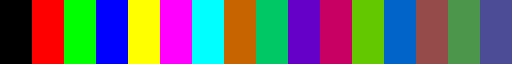

In [148]:
a = data[:,:,[1,2,3]]
cmap=plt.matplotlib.colors.ListedColormap(spectral.spy_colors/255,'Classification',NUM_CLASS)
cmap

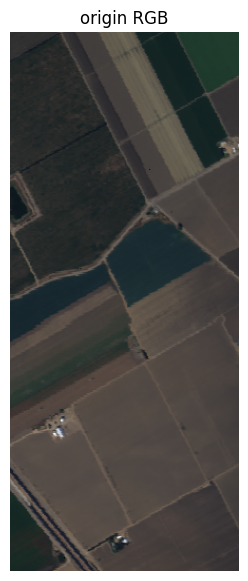

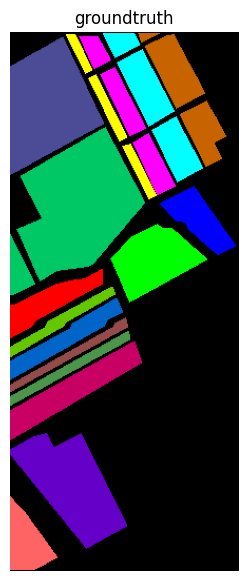

In [149]:
def img_display(data = None, rgb_band = None, classes = None,class_name = None,title = None, 
                figsize = (7,7),palette = spectral.spy_colors):
    if data is not None:
        im_rgb = np.zeros_like(data[:,:,0:3])
        im_rgb = data[:,:,rgb_band]
        im_rgb = im_rgb/(np.max(np.max(im_rgb,axis = 1),axis = 0))*255
        im_rgb = np.asarray(im_rgb,np.uint8)
        fig, rgbax = plt.subplots(figsize = figsize)
        rgbax.imshow(im_rgb)
        rgbax.set_title(title)
        rgbax.axis('off')
        
    elif classes is not None:
        rgb_class = np.zeros((classes.shape[0],classes.shape[1],3))
        for i in np.unique(classes):
            rgb_class[classes==i]=palette[i]
        rgb_class = np.asarray(rgb_class, np.uint8)
        _,classax = plt.subplots(figsize = figsize)
        classax.imshow(rgb_class)
        classax.set_title(title)
        classax.axis('off')
        # rect = [mpts.Rectangle((0,0),1,1,facecolor=palette[i]/255) for i in range(len(class_name))]
        # classax.legend(rect,class_name,bbox_to_anchor = (1.04,1),frameon=False,loc = 'upper left')
        
img_display(data,(30,20,10),title='origin RGB')
img_display(classes=label,title='groundtruth',class_name=class_name)

In [150]:
# ## display HSI
# rgb_view=spectral.imshow(data,(30,20,10),classes=label.astype(int),title='RGB origin',figsize=(7,7))
# gt_view = spectral.imshow(classes=label.astype(int), title='GroundTruth',figsize=(7,7))
# view = spectral.imshow(data,(30,20,10),classes=label.astype(int),figsize=(7,7))
# view.set_display_mode('overlay')
# view.set_title('Overlay')
spectral.save_rgb(f'C:/Users/coolp/Downloads/HSIConvKAN-main/HSIConvKAN-main/{DATASET}_RGB_origin.jpg',data,(30,20,10))
spectral.save_rgb(f'C:/Users/coolp/Downloads/HSIConvKAN-main/HSIConvKAN-main/{DATASET}_gt.jpg',label,colors = spectral.spy_colors)

In [151]:
def applyPCA(X, numComponents=15, norm = True):
    """PCA and processing
    Args:
        X (ndarray M*N*C): data needs DR
        numComponents (int, optional):  number of reserved components(Defaults to 15, 0 for no PCA).
        norm: normalization or not
    Returns:
        newX: processed data
        pca: 
    """
    
    if numComponents == 0:
        newX = np.reshape(X, (-1, X.shape[2]))
    else:
        newX = np.reshape(X, (-1, X.shape[2]))
        pca = PCA(n_components=numComponents)   ##PCA and normalization
        newX = pca.fit_transform(newX)
    if norm:
        newX = minmax_scale(newX, axis=1)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], -1))
    return newX, newX.shape[2]

In [152]:
data,N_PCA = applyPCA(data, N_PCA, NORM)
data.shape,N_PCA

((512, 217, 15), 15)

In [153]:
def sample_gt(gt, train_rate):
    """ generate training gt for training dataset
    Args:
        gt (ndarray): full classmap
        train_rate (float): ratio of training dataset
    Returns:
        train_gt(ndarray): classmap of training data
        test_gt(ndarray): classmap of test data
    """
    indices = np.nonzero(gt)  ##([x1,x2,...],[y1,y2,...])
    X = list(zip(*indices))  ## X=[(x1,y1),(x2,y2),...] location of pixels
    y = gt[indices].ravel()
    train_gt = np.zeros_like(gt)
    test_gt = np.zeros_like(gt)
    if train_rate > 1:
       train_rate = int(train_rate)
    train_indices, test_indices = train_test_split(X, train_size=train_rate, stratify=y, random_state=100)
    train_indices = [t for t in zip(*train_indices)]   ##[[x1,x2,...],[y1,y2,...]]
    test_indices = [t for t in zip(*test_indices)]
    train_gt[tuple(train_indices)] = gt[tuple(train_indices)]
    test_gt[tuple(test_indices)] = gt[tuple(test_indices)]
    
    return train_gt, test_gt

In [154]:
train_gt, test_gt = sample_gt(label,TRAIN_RATE)
val_gt,test_gt = sample_gt(test_gt,VAL_RATE/(1-TRAIN_RATE))

          class          train_num  val_num   test_num   total   
 Broccoli_green_weeds_1     1406      402       201       2009   
 Broccoli_green_weeds_2     2608      745       373       3726   
         Fallow             1383      395       198       1976   
    Fallow_rough_plow       976       279       139       1394   
      Fallow_smooth         1875      535       268       2678   
         Stubble            2771      792       396       3959   
         Celery             2505      716       358       3579   
    Grapes_untrained        7890      2254      1127     11271   
  Soil_vinyard_develop      4342      1241      620       6203   
Corn_senesced_green_weeds   2295      656       327       3278   
   Lettuce_romaine_4wk      748       213       107       1068   
   Lettuce_romaine_5wk      1349      386       192       1927   
   Lettuce_romaine_6wk      641       183        92       916    
   Lettuce_romaine_7wk      749       214       107       1070   
    Vinyar

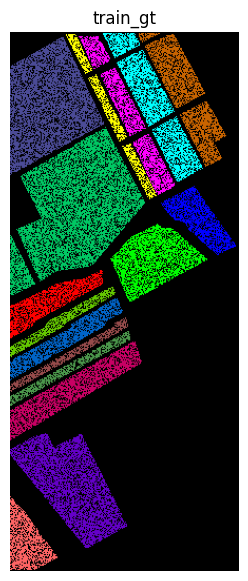

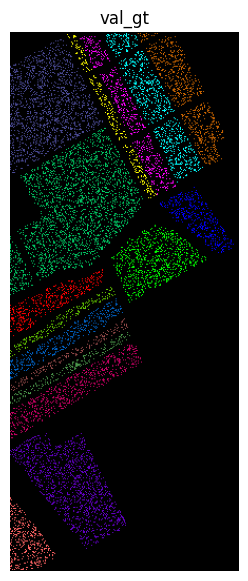

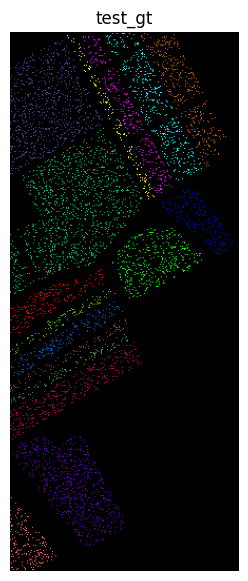

In [155]:
## display sampling info
sample_report = f"{'class': ^25}{'train_num':^10}{'val_num': ^10}{'test_num': ^10}{'total': ^10}\n"
for i in np.unique(label):
    if i == 0: continue
    sample_report += f"{class_name[i-1]: ^25}{(train_gt==i).sum(): ^10}{(val_gt==i).sum(): ^10}{(test_gt==i).sum(): ^10}{(label==i).sum(): ^10}\n"
sample_report += f"{'total': ^25}{np.count_nonzero(train_gt): ^10}{np.count_nonzero(val_gt): ^10}{np.count_nonzero(test_gt): ^10}{np.count_nonzero(label): ^10}"
print(sample_report)
img_display(classes=train_gt,title='train_gt')
img_display(classes=val_gt,title='val_gt')
img_display(classes=test_gt,title='test_gt')

# spectral.imshow(classes=train_gt, title='train_gt')
# spectral.imshow(classes=val_gt, title='val_gt')
# spectral.imshow(classes=test_gt, title='test_gt')

In [156]:
class PatchSet(Dataset):
    """ Generate 3D patch from hyperspectral dataset """
    def __init__(self, data, gt, patch_size, is_pred=False):
        """
        Args:
            data: 3D hyperspectral image
            gt: 2D array of labels
            patch_size: int, size of the 3D patch
            is_pred: bool, create data without label for prediction (default False) 
        """
        super(PatchSet, self).__init__()
        self.is_pred = is_pred
        self.patch_size = patch_size
        p = self.patch_size // 2
        self.data = np.pad(data,((p,p),(p,p),(0,0)),'constant',constant_values = 0)
        if is_pred:
            gt = np.ones_like(gt)
        self.label = np.pad(gt,(p,p),'constant',constant_values = 0)
        x_pos, y_pos = np.nonzero(gt)
        x_pos, y_pos = x_pos + p, y_pos + p   ##indices after padding
        self.indices = np.array([(x,y) for x,y in zip(x_pos, y_pos)])
        if not is_pred:
            np.random.shuffle(self.indices)

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, i):
        x, y = self.indices[i]
        x1, y1 = x - self.patch_size // 2, y - self.patch_size // 2
        x2, y2 = x1 + self.patch_size, y1 + self.patch_size
        data = self.data[x1:x2, y1:y2]
        label = self.label[x, y]
        data = np.asarray(data, dtype='float32').transpose((2, 0, 1))
        label = np.asarray(label, dtype='int64')
        data = torch.from_numpy(data)
        data = torch.reshape(data, (data.shape[0], data.shape[1], data.shape[2], 1))
        label = torch.from_numpy(label)
        if self.is_pred:
            return data
        else: return data, label


In [157]:
##create dataset and dataloader
train_data = PatchSet(data, train_gt, PATCH_SIZE)
val_data = PatchSet(data, val_gt, PATCH_SIZE)
all_data = PatchSet(data, label, PATCH_SIZE,is_pred = True)
train_loader = DataLoader(train_data,BATCH_SIZE,shuffle= True)
val_loader = DataLoader(val_data,BATCH_SIZE,shuffle= True)
all_loader = DataLoader(all_data,BATCH_SIZE,shuffle= False)

In [158]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        """
        Focal Loss:
        alpha: balancing factor, helps with class imbalance
        gamma: focusing parameter, helps focus on hard examples
        reduction: how to reduce loss ('mean', 'sum', 'none')
        """
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)  # pt is the probability of the target class
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss


In [159]:
d,g=train_data.__getitem__(0)
d.shape,g

(torch.Size([15, 9, 9, 1]), tensor(8))

In [160]:
#pip install unfoldNd

In [161]:
import torch.nn as nn
import torch.nn.functional as F
from ConvKAN import ConvKAN
from ConvKAN3D import effConvKAN3D
from fast_kan import FastKAN as KAN

In [162]:
in_chs=NUM_CLASS
patch_size=8


class Net(nn.Module):
    # Define the architecture of the network
    def __init__(self):
        super(Net, self).__init__()
        
        self.in_chs = in_chs
        self.patch_size = patch_size
        self.ConvKAN1 = effConvKAN3D(in_channels=15, out_channels=8, kernel_size=1)
        self.ConvKAN2 = effConvKAN3D(in_channels=8, out_channels=16, kernel_size=1)
        self.ConvKAN3 = effConvKAN3D(in_channels=16, out_channels=32, kernel_size=1)
        
        self.ConvKAN4 = ConvKAN(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1, version="Fast")
        self.pool = nn.MaxPool2d(kernel_size=3, stride=3)
        
        # 5*5 from image dimension
        #self.KAN1 =  KAN([4 * 4 * 4 , 64, 32])
        self.KAN1 = KAN([64, 32, NUM_CLASS])

    # Set the flow of data through the network for the forward pass
    # x represents the data
    def forward(self, x):
        # F.relu is the rectified-linear activation function
        
        x = self.ConvKAN1(x)
        x = self.ConvKAN2(x)
        x = self.ConvKAN3(x)
        x = x.view(x.shape[0], x.shape[1], x.shape[2], x.shape[3]*x.shape[4])
        x = self.pool(self.ConvKAN4(x))

        # flatten all dimensions except the batch dimension
        x = torch.flatten(x, 1)
        x = self.KAN1(x)
        #x = self.KAN2(x)
        #x = self.KAN3(x)
        output = F.log_softmax(x, dim=1)
        
        return output

In [163]:
#instantiate CNN model
model = Net()
model

Net(
  (ConvKAN1): effConvKAN3D(
    (unfold): UnfoldNd()
    (linear): KANLinear(
      (base_activation): SiLU()
    )
  )
  (ConvKAN2): effConvKAN3D(
    (unfold): UnfoldNd()
    (linear): KANLinear(
      (base_activation): SiLU()
    )
  )
  (ConvKAN3): effConvKAN3D(
    (unfold): UnfoldNd()
    (linear): KANLinear(
      (base_activation): SiLU()
    )
  )
  (ConvKAN4): ConvKAN(
    (unfold): Unfold(kernel_size=3, dilation=1, padding=1, stride=2)
    (linear): Fast_KANLinear(
      (layernorm): LayerNorm((288,), eps=1e-05, elementwise_affine=True)
      (rbf): RadialBasisFunction()
      (spline_linear): SplineLinear(in_features=1440, out_features=64, bias=False)
      (base_activation): SiLU()
      (base_linear): Linear(in_features=288, out_features=64, bias=True)
    )
  )
  (pool): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (KAN1): FastKAN(
    (layers): ModuleList(
      (0): Fast_KANLinear(
        (layernorm): LayerNorm((64,), eps=1e-05, e

In [164]:
torch.cuda.is_available()

False

In [165]:
#PATH = 'E:/Roy/Sim Pool/Results/Training/3D2DConvKAN_Indian_pines_30.pth'
#model.load_state_dict(torch.load(PATH))
#moel=torch.load(PATH)

In [172]:
EPOCH=50


## training the model
device = torch.device(DEVICE if DEVICE>=0 and torch.cuda.is_available() else 'cpu')

loss_list = []
acc_list = []
val_acc_list = []
val_epoch_list = []
epoch_start = 0

model = model ##modify to you model 
model.to(device)
optimizer = torch.optim.Adam(model.parameters(),LR,weight_decay=WEIGHT_DECAY)


if CHECK_POINT is not None:
    model_ckpt = torch.load(CHECK_POINT,map_location = device)
    model.load_state_dict(model_ckpt['state_dict'])
    epoch_start = model_ckpt['epoch']
    optimizer.load_state_dict(model_ckpt['optimizer'])
    loss_list = model_ckpt['loss_list']
    acc_list = model_ckpt['acc_list']
    val_acc_list = model_ckpt['val_acc_list']
    val_epoch_list = model_ckpt['val_epoch_list']

loss_func = FocalLoss(alpha=1, gamma=2, reduction='mean')
batch_num = len(train_loader)
train_num = train_loader.dataset.__len__()
val_num = val_loader.dataset.__len__()
train_st = time.time()
run_error = False
e=None
try:
    for e in tqdm(range(epoch_start,EPOCH), desc="Training:"):
        
        model.train()
        avg_loss = 0.0
        train_acc = 0
        
        for batch_idx, (data, target) in tqdm(enumerate(train_loader),total=batch_num):
            
            data,target = data.to(device),target.to(device)
            optimizer.zero_grad()
            out = model(data)
            target = target - 1  ## class 0 in out is class 1 in target
            loss = loss_func(out,target)
            loss.backward()
            optimizer.step()
            
            avg_loss += loss.item()
            _,pred = torch.max(out,dim=1)
            train_acc += (pred == target).sum().item()
        loss_list.append(avg_loss/train_num)
        acc_list.append(train_acc/train_num)
        print(f"epoch {e}/{EPOCH} loss:{loss_list[e]}  acc:{acc_list[e]}")
        ## valuation
        if (e+1)%VAL_EPOCH == 0 or (e+1)==EPOCH:
            
            val_acc =0
            model.eval()
            
            for batch_idx, (data, target) in tqdm(enumerate(val_loader),total=len(val_loader)):
                
                data,target = data.to(device),target.to(device)
                out = model(data)
                target = target - 1  ## class 0 in out is class 1 in target
                _,pred = torch.max(out,dim=1)
                val_acc += (pred == target).sum().item()
                writer.add_scalar('Loss/train', avg_loss / train_num, e)
                writer.add_scalar('Accuracy/train', train_acc / train_num, e)
            writer.close()
            val_acc_list.append(val_acc/val_num)
            val_epoch_list.append(e)
            print(f"epoch {e}/{EPOCH}  val_acc:{val_acc_list[-1]}")
            save_name = os.path.join(SAVE_PATH, f"epoch_{e}_acc_{val_acc_list[-1]:.4f}.pth")
            save_dict = {'state_dict':model.state_dict(), 'epoch':e+1, 'optimizer': optimizer.state_dict(),
                        'loss_list':loss_list, 'acc_list': acc_list, 'val_acc_list': val_acc_list, 'val_epoch_list':val_epoch_list}
            torch.save(save_dict,save_name)
except Exception as exc:
    print(exc)
    run_error = True
finally: 
    print(f'Stop in epoch {e}')
train_time = time.time()-train_st
print(f"training time: {train_time}")

Training::   0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/593 [00:00<?, ?it/s]

epoch 0/50 loss:0.0004528189751578411  acc:0.9561097915017155


  0%|          | 0/170 [00:00<?, ?it/s]

epoch 0/50  val_acc:0.9622205800849806


  0%|          | 0/593 [00:00<?, ?it/s]

epoch 1/50 loss:0.00046407154918687386  acc:0.9572182633940354


  0%|          | 0/170 [00:00<?, ?it/s]

epoch 1/50  val_acc:0.968501755034177


  0%|          | 0/593 [00:00<?, ?it/s]

epoch 2/50 loss:0.0004646676616862664  acc:0.9553708102401689


  0%|          | 0/170 [00:00<?, ?it/s]

epoch 2/50  val_acc:0.9539072602992795


  0%|          | 0/593 [00:00<?, ?it/s]

epoch 3/50 loss:0.00043988274039924495  acc:0.9591185009237265


  0%|          | 0/170 [00:00<?, ?it/s]

epoch 3/50  val_acc:0.9625900609643451


  0%|          | 0/593 [00:00<?, ?it/s]

epoch 4/50 loss:0.00035152139675129353  acc:0.9660068619688572


  0%|          | 0/170 [00:00<?, ?it/s]

epoch 4/50  val_acc:0.9574173286532422


  0%|          | 0/593 [00:00<?, ?it/s]

epoch 5/50 loss:0.0003698217425068684  acc:0.9642385853787279


  0%|          | 0/170 [00:00<?, ?it/s]

epoch 5/50  val_acc:0.9683170145944947


  0%|          | 0/593 [00:00<?, ?it/s]

epoch 6/50 loss:0.0003750508254544854  acc:0.9651623119556612


  0%|          | 0/170 [00:00<?, ?it/s]

epoch 6/50  val_acc:0.9714576020690929


  0%|          | 0/593 [00:00<?, ?it/s]

epoch 7/50 loss:0.0003426198900283469  acc:0.9665347057271048


  0%|          | 0/170 [00:00<?, ?it/s]

epoch 7/50  val_acc:0.9612968778865694


  0%|          | 0/593 [00:00<?, ?it/s]

epoch 8/50 loss:0.00036134196221794047  acc:0.9664555291633676


  0%|          | 0/170 [00:00<?, ?it/s]

epoch 8/50  val_acc:0.9749676704230557


  0%|          | 0/593 [00:00<?, ?it/s]

epoch 9/50 loss:0.0003128540882978153  acc:0.9698865135919768


  0%|          | 0/170 [00:00<?, ?it/s]

epoch 9/50  val_acc:0.9756142619619435


  0%|          | 0/593 [00:00<?, ?it/s]

epoch 10/50 loss:0.0003709169127063022  acc:0.9659276854051201


  0%|          | 0/170 [00:00<?, ?it/s]

epoch 10/50  val_acc:0.9698873083317938


  0%|          | 0/593 [00:00<?, ?it/s]

epoch 11/50 loss:0.00030686013412510436  acc:0.9703087885985748


  0%|          | 0/170 [00:00<?, ?it/s]

epoch 11/50  val_acc:0.9659153888786255


  0%|          | 0/593 [00:00<?, ?it/s]

epoch 12/50 loss:0.00025463655750671417  acc:0.9747162839799419


  0%|          | 0/170 [00:00<?, ?it/s]

epoch 12/50  val_acc:0.9766303343801959


  0%|          | 0/593 [00:00<?, ?it/s]

epoch 13/50 loss:0.0003543205090796471  acc:0.968223805753497


  0%|          | 0/170 [00:00<?, ?it/s]

epoch 13/50  val_acc:0.9514132643635692


  0%|          | 0/593 [00:00<?, ?it/s]

epoch 14/50 loss:0.0003666473088181147  acc:0.9677751385589866


  0%|          | 0/170 [00:00<?, ?it/s]

epoch 14/50  val_acc:0.949750600406429


  0%|          | 0/593 [00:00<?, ?it/s]

epoch 15/50 loss:0.00030044239164497626  acc:0.9727896542623383


  0%|          | 0/170 [00:00<?, ?it/s]

epoch 15/50  val_acc:0.9785701089968594


  0%|          | 0/593 [00:00<?, ?it/s]

epoch 16/50 loss:0.00025803659448624615  acc:0.9754816574294009


  0%|          | 0/170 [00:00<?, ?it/s]

epoch 16/50  val_acc:0.9778311472381305


  0%|          | 0/593 [00:00<?, ?it/s]

epoch 17/50 loss:0.00023797115040125668  acc:0.9778305621536025


  0%|          | 0/170 [00:00<?, ?it/s]

epoch 17/50  val_acc:0.9769074450397192


  0%|          | 0/593 [00:00<?, ?it/s]

epoch 18/50 loss:0.00023267779718481318  acc:0.9783320137239377


  0%|          | 0/170 [00:00<?, ?it/s]

epoch 18/50  val_acc:0.9783853685571772


  0%|          | 0/593 [00:00<?, ?it/s]

epoch 19/50 loss:0.00023918967851987264  acc:0.9780153074689891


  0%|          | 0/170 [00:00<?, ?it/s]

epoch 19/50  val_acc:0.9782929983373361


  0%|          | 0/593 [00:00<?, ?it/s]

epoch 20/50 loss:0.0002294234269170553  acc:0.9782528371602006


  0%|          | 0/170 [00:00<?, ?it/s]

epoch 20/50  val_acc:0.9749676704230557


  0%|          | 0/593 [00:00<?, ?it/s]

epoch 21/50 loss:0.000248859110763938  acc:0.9778041699656902


  0%|          | 0/170 [00:00<?, ?it/s]

epoch 21/50  val_acc:0.9811564751524109


  0%|          | 0/593 [00:00<?, ?it/s]

epoch 22/50 loss:0.00020488737732012613  acc:0.9809184481393508


  0%|          | 0/170 [00:00<?, ?it/s]

epoch 22/50  val_acc:0.976722704600037


  0%|          | 0/593 [00:00<?, ?it/s]

epoch 23/50 loss:0.00019807646942030473  acc:0.9816046450250726


  0%|          | 0/170 [00:00<?, ?it/s]

epoch 23/50  val_acc:0.9795861814151118


  0%|          | 0/593 [00:00<?, ?it/s]

epoch 24/50 loss:0.0001946886093340977  acc:0.982475587226181


  0%|          | 0/170 [00:00<?, ?it/s]

epoch 24/50  val_acc:0.9143728062072788


  0%|          | 0/593 [00:00<?, ?it/s]

epoch 25/50 loss:0.0002247876915419521  acc:0.9792557403008709


  0%|          | 0/170 [00:00<?, ?it/s]

epoch 25/50  val_acc:0.9780158876778127


  0%|          | 0/593 [00:00<?, ?it/s]

epoch 26/50 loss:0.00020904937770924506  acc:0.9814462918975984


  0%|          | 0/170 [00:00<?, ?it/s]

epoch 26/50  val_acc:0.9810641049325698


  0%|          | 0/593 [00:00<?, ?it/s]

epoch 27/50 loss:0.0001913707356940349  acc:0.9820797044074954


  0%|          | 0/170 [00:00<?, ?it/s]

epoch 27/50  val_acc:0.9671162017365601


  0%|          | 0/593 [00:00<?, ?it/s]

epoch 28/50 loss:0.000158150085504304  acc:0.9852731591448931


  0%|          | 0/170 [00:00<?, ?it/s]

epoch 28/50  val_acc:0.9679475337151302


  0%|          | 0/593 [00:00<?, ?it/s]

epoch 29/50 loss:0.000139348552074644  acc:0.986381631037213


  0%|          | 0/170 [00:00<?, ?it/s]

epoch 29/50  val_acc:0.9783853685571772


  0%|          | 0/593 [00:00<?, ?it/s]

epoch 30/50 loss:0.00016932855066203147  acc:0.9841382950646609


  0%|          | 0/170 [00:00<?, ?it/s]

epoch 30/50  val_acc:0.9658230186587844


  0%|          | 0/593 [00:00<?, ?it/s]

epoch 31/50 loss:0.00020432800597832196  acc:0.9827922934811296


  0%|          | 0/170 [00:00<?, ?it/s]

epoch 31/50  val_acc:0.9777387770182893


  0%|          | 0/593 [00:00<?, ?it/s]

epoch 32/50 loss:0.00010543911345723217  acc:0.9896014779625231


  0%|          | 0/170 [00:00<?, ?it/s]

epoch 32/50  val_acc:0.9807869942730464


  0%|          | 0/593 [00:00<?, ?it/s]

epoch 33/50 loss:0.00016974623950148342  acc:0.984850884138295


  0%|          | 0/170 [00:00<?, ?it/s]

epoch 33/50  val_acc:0.9826343986698688


  0%|          | 0/593 [00:00<?, ?it/s]

epoch 34/50 loss:0.00017368796542106826  acc:0.9862232779097387


  0%|          | 0/170 [00:00<?, ?it/s]

epoch 34/50  val_acc:0.906983188619989


  0%|          | 0/593 [00:00<?, ?it/s]

epoch 35/50 loss:0.0002799569298399644  acc:0.975349696489839


  0%|          | 0/170 [00:00<?, ?it/s]

epoch 35/50  val_acc:0.9545538518381673


  0%|          | 0/593 [00:00<?, ?it/s]

epoch 36/50 loss:0.00013122816382992575  acc:0.9876484560570071


  0%|          | 0/170 [00:00<?, ?it/s]

epoch 36/50  val_acc:0.9796785516349529


  0%|          | 0/593 [00:00<?, ?it/s]

epoch 37/50 loss:0.00013857164139985693  acc:0.9888097123251518


  0%|          | 0/170 [00:00<?, ?it/s]

epoch 37/50  val_acc:0.9813412155920931


  0%|          | 0/593 [00:00<?, ?it/s]

epoch 38/50 loss:0.0001667818434358799  acc:0.9854579044602798


  0%|          | 0/170 [00:00<?, ?it/s]

epoch 38/50  val_acc:0.9837428413079623


  0%|          | 0/593 [00:00<?, ?it/s]

epoch 39/50 loss:0.0001018677070619091  acc:0.9905515967273687


  0%|          | 0/170 [00:00<?, ?it/s]

epoch 39/50  val_acc:0.9821725475706632


  0%|          | 0/593 [00:00<?, ?it/s]

epoch 40/50 loss:0.00012756922906615996  acc:0.9892583795196622


  0%|          | 0/170 [00:00<?, ?it/s]

epoch 40/50  val_acc:0.9814335858119342


  0%|          | 0/593 [00:00<?, ?it/s]

epoch 41/50 loss:0.00014332102976297043  acc:0.9894695170229612


  0%|          | 0/170 [00:00<?, ?it/s]

epoch 41/50  val_acc:0.8782560502493996


  0%|          | 0/593 [00:00<?, ?it/s]

epoch 42/50 loss:0.0004528885055150637  acc:0.9647400369490631


  0%|          | 0/170 [00:00<?, ?it/s]

epoch 42/50  val_acc:0.9646222058008498


  0%|          | 0/593 [00:00<?, ?it/s]

epoch 43/50 loss:0.0001427388596516835  acc:0.9873317498020586


  0%|          | 0/170 [00:00<?, ?it/s]

epoch 43/50  val_acc:0.9864215776833549


  0%|          | 0/593 [00:00<?, ?it/s]

epoch 44/50 loss:9.570954403255158e-05  acc:0.9914225389284772


  0%|          | 0/170 [00:00<?, ?it/s]

epoch 44/50  val_acc:0.9786624792167006


  0%|          | 0/593 [00:00<?, ?it/s]

epoch 45/50 loss:9.13956039088907e-05  acc:0.9919239904988123


  0%|          | 0/170 [00:00<?, ?it/s]

epoch 45/50  val_acc:0.984297062627009


  0%|          | 0/593 [00:00<?, ?it/s]

epoch 46/50 loss:0.00017434631710461175  acc:0.9856690419635787


  0%|          | 0/170 [00:00<?, ?it/s]

epoch 46/50  val_acc:0.9855902457047848


  0%|          | 0/593 [00:00<?, ?it/s]

epoch 47/50 loss:8.436513179430305e-05  acc:0.9929532858273951


  0%|          | 0/170 [00:00<?, ?it/s]

epoch 47/50  val_acc:0.9729355255865509


  0%|          | 0/593 [00:00<?, ?it/s]

epoch 48/50 loss:8.910151920557965e-05  acc:0.9919239904988123


  0%|          | 0/170 [00:00<?, ?it/s]

epoch 48/50  val_acc:0.985036024385738


  0%|          | 0/593 [00:00<?, ?it/s]

epoch 49/50 loss:0.00011418053900866062  acc:0.9908419107944049


  0%|          | 0/170 [00:00<?, ?it/s]

epoch 49/50  val_acc:0.9853131350452614
Stop in epoch 49
training time: 3294.473096370697


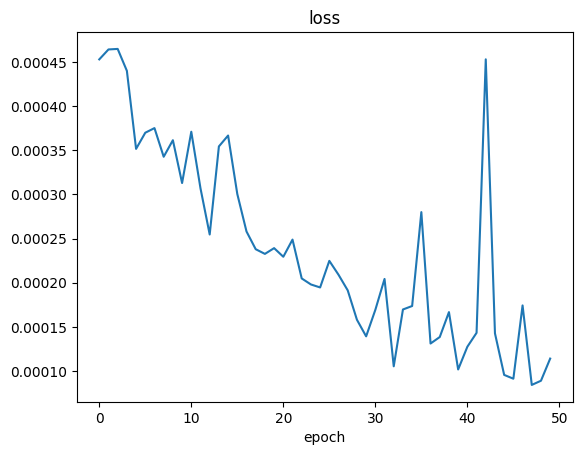

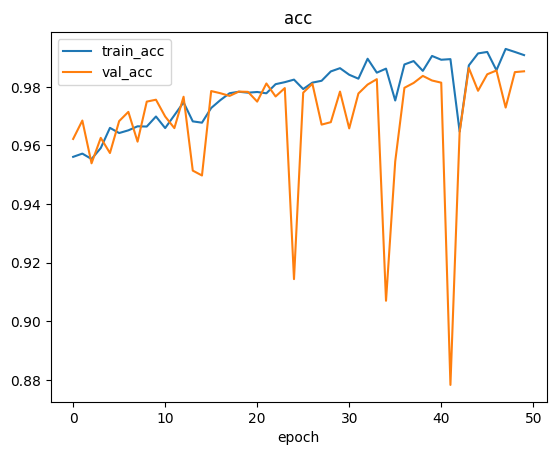

In [173]:
##display loss and acc
fig1 = plt.figure()
fig2 = plt.figure()
ax1 = fig1.add_subplot(1,1,1)
ax2 = fig2.add_subplot(1,1,1)
ax1.plot(np.arange(e+1),loss_list)
ax1.set_title('loss')
ax1.set_xlabel('epoch')


ax2.plot(np.arange(e+1),acc_list,label = 'train_acc')
ax2.plot(val_epoch_list,val_acc_list,label = 'val_acc')
ax2.set_title('acc')
ax2.set_xlabel('epoch')
ax2.legend()

In [174]:
## get best model path and del other models
def get_best_model(acc_list, epoch_list, save_path, del_others = True):
    """get best model path by valuation list
    Args:
        acc_list (list): list of valuation accuracy
        epoch_list (list): list of valuation epoch
        save_path (str): path of save dir
    Returns:
        best_model_path: path of best model
    """
    acc_list = np.array(acc_list)
    epoch_list = np.array(epoch_list)
    best_index = np.argwhere(acc_list==np.max(acc_list))[-1].item()
    best_epoch = epoch_list[best_index]
    best_acc = acc_list[best_index]
    file_name = f"epoch_{best_epoch}_acc_{best_acc:.4f}.pth"
    best_model_path=os.path.join(save_path, file_name)
    print(f"best model:{file_name}")
    ##del save model except best model
    if del_others:
        for f in os.listdir(save_path):
            if f[-3:]=='pth' and os.path.join(save_path,f)!=best_model_path:
                os.remove(os.path.join(save_path,f))
    return best_model_path

In [175]:
# save
PATH = 'C:/Users/coolp/Downloads/HSIConvKAN-main/HSIConvKAN-main/Training/3D2D1DConvKAN_PaviaU_30.pth'
torch.save(model.state_dict(), PATH)
# reload


best model:epoch_43_acc_0.9864.pth


C:\Users\coolp\AppData\Local\Temp\ipykernel_18452\3376600633.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_path)['stat

  0%|          | 0/1736 [00:00<?, ?it/s]

inferring time: 63.87817573547363


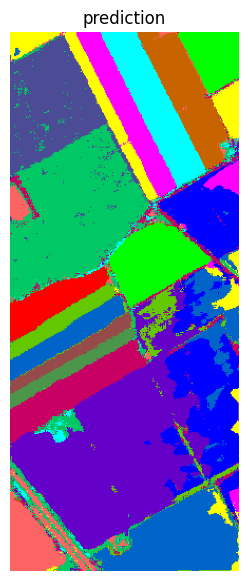

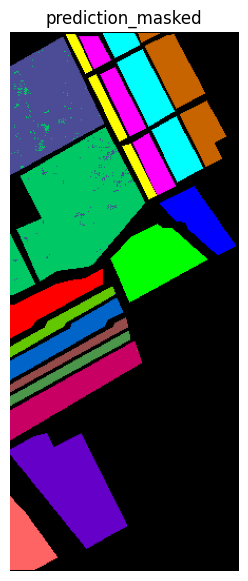

In [176]:
## inferring the whole image
##load best model
best_model_path = get_best_model(val_acc_list,val_epoch_list,SAVE_PATH, not run_error)

best_model = model  ## modify to your model

best_model.load_state_dict(torch.load(best_model_path)['state_dict'])
## inference
best_model
best_model.eval()
pred_map = []
infer_st = time.time()

for batch_idx, data in tqdm(enumerate(all_loader),total=len(all_loader)):
    
    data = data.to(device)
    target = best_model(data)
    _, pred = torch.max(target, dim = 1)
    pred_map += [np.array(pred.detach().cpu() + 1)]   ## class 0 in pred_map is class 1 in gt
infer_time = time.time() - infer_st


print(f"inferring time: {infer_time}")
pred_map = np.asarray(np.hstack(pred_map),dtype=np.uint8).reshape(label.shape[0],label.shape[1])
img_display(classes=pred_map,title='prediction',figsize=(7,7))
img_display(classes=pred_map*(label!=0),title='prediction_masked',figsize=(7,7))
# spectral.imshow(classes=pred_map,title='prediction',figsize=(7,7))
# spectral.imshow(classes=pred_map*(label!=0),title='prediction_masked',figsize=(7,7))
spectral.save_rgb(os.path.join(SAVE_PATH,f"C:/Users/coolp/Downloads/HSIConvKAN-main/HSIConvKAN-main/Results/3D2D1DConvKAN_prediction_PaviaU.jpg"),pred_map,colors = spectral.spy_colors)
spectral.save_rgb(os.path.join(SAVE_PATH,f"C:/Users/coolp/Downloads/HSIConvKAN-main/HSIConvKAN-main/Results/3D2D1DConvKAN__prediction_masked_Qingyun.jpg"),pred_map*(label!=0),colors = spectral.spy_colors)

In [177]:
## classfication report
test_pred = pred_map[test_gt!=0]
test_true = test_gt[test_gt!=0]

OA = accuracy_score(test_true,test_pred)
AA = recall_score(test_true,test_pred,average='macro')
kappa = cohen_kappa_score(test_true,test_pred)
report_log = F"OA: {OA}\nAA: {AA}\nKappa: {kappa}\n"
report_log += f"training time: {train_time}\ninferring time: {infer_time}\n"
report_log += classification_report(test_true,test_pred,target_names=class_name,digits=4)
print(report_log)
fp = open(os.path.join(SAVE_PATH,'C:/Users/coolp/Downloads/HSIConvKAN-main/HSIConvKAN-main/Results/3D2D1DConvKAN_Qingyun_30_report.txt'),'w+')
fp.writelines(report_log)
fp.close()

OA: 0.9848512839460558
AA: 0.9942320179073364
Kappa: 0.9831331859144208
training time: 3294.473096370697
inferring time: 63.87817573547363
                           precision    recall  f1-score   support

   Broccoli_green_weeds_1     1.0000    1.0000    1.0000       201
   Broccoli_green_weeds_2     1.0000    1.0000    1.0000       373
                   Fallow     1.0000    1.0000    1.0000       198
        Fallow_rough_plow     1.0000    1.0000    1.0000       139
            Fallow_smooth     1.0000    1.0000    1.0000       268
                  Stubble     1.0000    1.0000    1.0000       396
                   Celery     1.0000    1.0000    1.0000       358
         Grapes_untrained     0.9644    0.9627    0.9636      1127
     Soil_vinyard_develop     1.0000    1.0000    1.0000       620
Corn_senesced_green_weeds     0.9970    1.0000    0.9985       327
      Lettuce_romaine_4wk     1.0000    1.0000    1.0000       107
      Lettuce_romaine_5wk     1.0000    1.0000    1.0000